In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
import matplotlib.pyplot as plt
import numpy as np

### Data defintion

In [ ]:
# remove virginica class
data_X = iris.data[iris.target != 2]
data_X = data_X[:, :2]  # only 2 features
# 1 if class is virginica, -1 if class is setosa
data_y = np.array([1 if i == 1 else -1 for i in iris.target[iris.target != 2]])

Utilization of only 10 data points for semplicty

In [ ]:
data_X = data_X[45:55]
data_y = data_y[45:55]

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

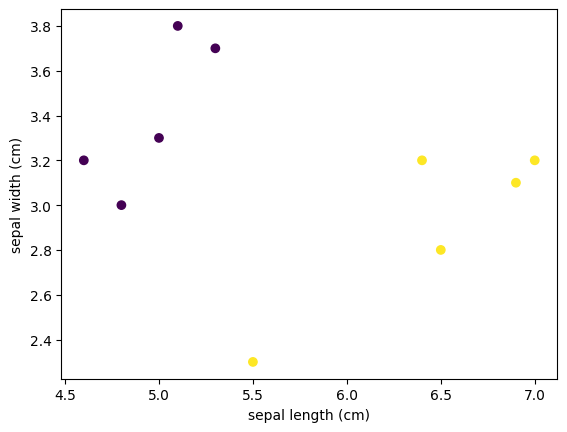

In [ ]:
_, ax = plt.subplots()
scatter = ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

In [ ]:
x = np.ones(3)
x[2] = 0
u = np.zeros(len(data_y))

# concatenate x and u
y_0 = np.concatenate((x, u))

# Resolution of the ODE system phi using the IVP solver

In [ ]:
def phi(t, y_hat): # y_hat = prediction(t) [103, 100]
    w = y_hat[:data_X.shape[1]]
    b = y_hat[data_X.shape[1]]
    u = y_hat[data_X.shape[1] + 1:]

    df = np.zeros(data_X.shape[1] + 1)
    df[0:-1] = w

    dg = - data_X * data_y[:, np.newaxis]
    dg = np.concatenate((dg, -data_y[:, np.newaxis]), axis=1)

    g = - data_y * (np.matmul(data_X, w) + b) + 1
    u_ = np.maximum((u + g), np.zeros(g.shape))

    # diff equations
    dxdt = - df - np.matmul(dg.T, u_)
    dudt = (-u + u_) / 2
    return np.concatenate((dxdt, dudt), axis=0)

In [ ]:
from scipy.integrate import solve_ivp
t_span = (0, 500)  # Integrate from t=0 to t=100
t_eval = np.linspace(t_span[0], t_span[1], 1000)

In [ ]:
solution = solve_ivp(phi, t_span, y_0, t_eval=t_eval)

The system did not converge within the time span.


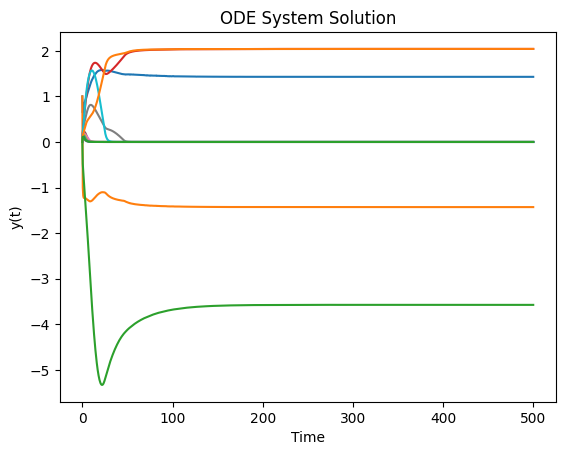

In [ ]:
# Extract the solution
t_values = solution.t
y_values = solution.y

# Determine convergence
# Here we check if the solution y(t) has reached a steady state
tolerance = 1e-6
steady_state_reached = np.all(np.abs(y_values[:, -1] - y_values[:, -2]) < tolerance)

if steady_state_reached:
    print(f"The system converged to {y_values[:, -1]} at t={t_values[-1]}")
else:
    print("The system did not converge within the time span.")

# If you want to see the solution
import matplotlib.pyplot as plt

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

In [ ]:
res = y_values[:,-1]

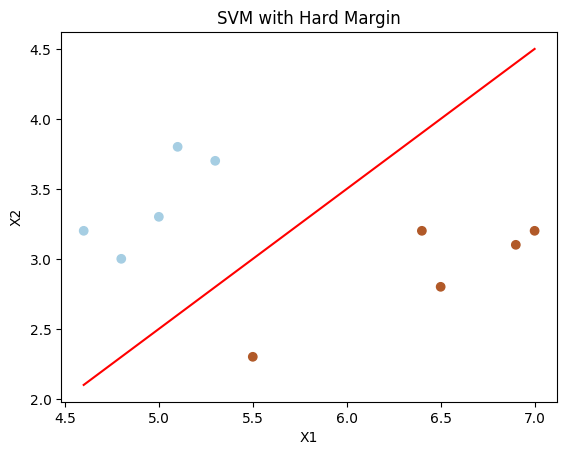

In [ ]:
w = res[0:2]
b = res[2]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w[0] / w[1]) * x_plot - b / w[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Neural network resolution

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.func import functional_call, grad, vmap
import torch

from IPython import display
import time
print(torch.cuda.is_available())

False


In [ ]:
class LinearModel(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        num_outputs: int = 1,
        act: nn.Module = nn.ReLU(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = torch.tensor(num_inputs)
        self.num_neurons = torch.tensor(num_neurons)
        self.num_layers = torch.tensor(num_layers)
        self.num_outputs = torch.tensor(num_outputs)

        self.hidden = nn.Linear(num_inputs, num_neurons)
        self.act = nn.Tanh()
        self.output = nn.Linear(num_neurons, num_outputs)

        """
        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, self.num_neurons))

        # hidden layers
        for _ in range(self.num_layers):
            layers.append(act)
            layers.append(nn.Linear(self.num_neurons, self.num_neurons))

        # output layer
        layers.append(act)
        layers.append(nn.Linear(num_neurons, num_outputs))

        # stitch the layers together
        self.linear = nn.Sequential(*layers)
        """

    def forward(self, x):
        x = self.hidden(x)
        x = self.act(x)
        x = self.output(x)
        return x
        #return self.linear(x)



In [ ]:
class DE_NN:
    # constructor
    def __init__(self, data_X, data_y, t_0, T, y_0, alpha) -> None: # n neurons and alpha
        self.data_X = torch.tensor(data_X)
        self.data_y = torch.tensor(data_y[:, np.newaxis])
        self.t_0 = t_0
        self.T = T
        self.y_0 = torch.tensor(y_0[:, np.newaxis])

        # TODO check size of y_0 makes sense with data_X

        self.x = self.y_0[:self.data_X.shape[1] + 1]
        self.u = self.y_0[self.data_X.shape[1] + 1:]

        # Neural network
        self.NN_model = LinearModel(num_inputs=1, num_layers=1, num_neurons=500, num_outputs=y_0.shape[0])

        self.optimizer = optim.Adam(self.NN_model.parameters(), lr=alpha)

    # system of differential equations
    def phi(self, y_hat): # y_hat = prediction(t) [103, 100]
        w = y_hat[:self.data_X.shape[1], :]
        b = y_hat[self.data_X.shape[1], :]
        u = y_hat[self.data_X.shape[1] + 1:, :]

        df = torch.zeros(self.data_X.shape[1] + 1, y_hat.shape[1])
        df[0:-1] = w

        dg = - self.data_X * self.data_y
        dg = torch.cat((dg, -self.data_y), dim=1)

        g = - self.data_y * (torch.matmul(self.data_X, w) + b) + 1
        u_ = torch.maximum((u + g), torch.zeros(g.shape))

        # diff equations
        dxdt = - df - torch.matmul(dg.T, u_)
        dudt = (-u + u_) / 2

        return torch.cat((dxdt, dudt), dim=0)

    def predict(self, t):
        y_pred_model = self.NN_model(t).T
        y_hat = self.y_0 + (1 - torch.exp(-(t - self.t_0))).T * y_pred_model

        return y_hat

    # Objective value under Constraints metric
    def OuC(self, y_pred):
        w = y_pred[0:self.data_X.shape[1]]
        b = y_pred[self.data_X.shape[1]]

        # Check if the constraints are satisfied
        g = - self.data_y * (torch.matmul(self.data_X, w) + b) + 1

        if torch.any(g > 0):
            return torch.inf

        return torch.linalg.norm(w)**2 / 2

    def train(self, max_iter, batch_size):

        # setup plots
        #fig, axes = plt.subplots(2, 1, figsize=(10, 6))

        # get initial values
        with torch.no_grad():
          y_best = self.predict(torch.tensor([[self.T]], dtype=torch.float))
        OuC_best = self.OuC(y_best)

        # loss list
        loss_list = []
        OuC_list = []

        for i in range(max_iter):
            # sample collocation points t form [t_0, T]
            t = torch.FloatTensor(batch_size, 1).uniform_(self.t_0, self.T)

            # forward prop
            y_hat = self.predict(t)

            # compute loss
            self.optimizer.zero_grad()

            ode_derivatives = self.phi(y_hat)
            loss = self.loss_fn(t, ode_derivatives)

            # backprop
            loss.backward()
            loss_list.append(loss.detach().numpy())

            # update weights
            self.optimizer.step()

            # predict final value
            with torch.no_grad():
              y_curr = self.predict(torch.tensor([[self.T]], dtype=torch.float))
            OuC_curr = self.OuC(y_curr)
            OuC_list.append(OuC_curr)

            # update best solution
            if OuC_curr < OuC_best:
                print(f"BEST {i}")
                y_best = y_curr
                OuC_best = OuC_curr

            #self.update_plot(loss_list, OuC_list, axes, i)

        return y_best, loss_list, OuC_list

    def compute_derivatives(self, t):
      t.requires_grad = True
      y_hat = self.NN_model(t)

      dydt_list = []
      for i in range(y_hat.shape[1]):  # Loop over each output dimension
          dydt = torch.autograd.grad(outputs=y_hat[:, i], inputs=t,
                                    grad_outputs=torch.ones_like(y_hat[:, i]),
                                    create_graph=True)[0]
          dydt_list.append(dydt)
      dydt = torch.stack(dydt_list, dim=1)

      t.requires_grad = False

      return y_hat, dydt

    def loss_fn(self, t, ode_derivatives) -> torch.Tensor:
        y_hat, dNdt = self.compute_derivatives(t)

        dNdt = dNdt.squeeze()

        dydt = torch.exp(-(t - self.t_0)) * y_hat + (1 - torch.exp(-(t - self.t_0))) * dNdt

        loss = torch.mean(torch.sqrt((dydt - ode_derivatives.T) ** 2))
        return loss

    def update_plot(self, loss_list, OuC_list, axes, i):

      axes[0].cla()  # Clear loss line data
      axes[0].plot(loss_list, label='Training Loss')
      axes[1].cla()  # Clear metric 1 line data

      for i, loss in enumerate(OuC_list):
        if np.isinf(loss):
            axes[1].plot(i, 0, 'ro')  # Plotting inf values as red points
        else:
            axes[1].plot(i, loss, 'bo')  # Plotting other values as blue points


      plt.tight_layout()  # Adjust layout to prevent overlapping elements
      plt.draw()


In [ ]:
de = DE_NN(data_X, data_y, 0, 100, y_0, 0.001)

In [ ]:
y_best, loss_list, OuC_list = de.train(2000, 100)

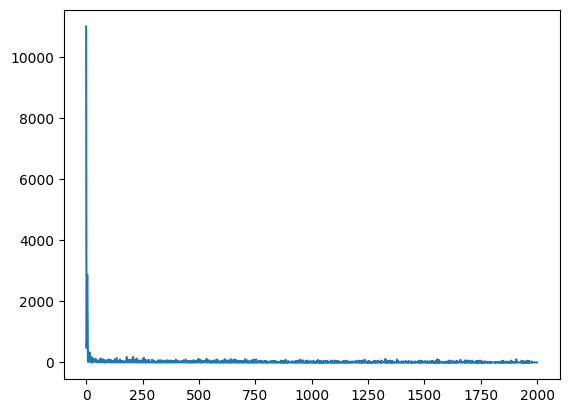

In [ ]:
plt.plot(loss_list)

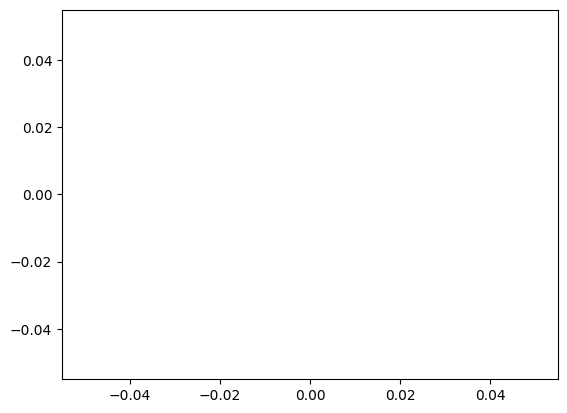

In [ ]:
_, ax = plt.subplots()
for i, loss in enumerate(OuC_list):
  if np.isinf(loss):
      ax.plot(i, loss, 'ro')  # Plotting inf values as red points
  else:
      ax.plot(i, loss, 'bo')

In [ ]:
w = y_best[0:2]
b = y_best[2]

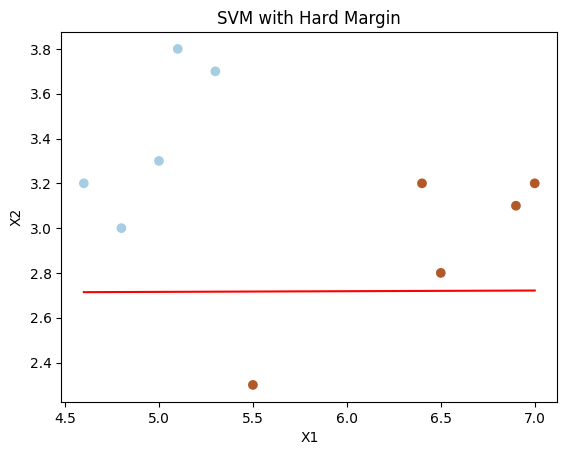

In [ ]:
# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w[0] / w[1]) * x_plot - b / w[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()